In [ ]:
pip install requests --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 755.0 kB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.


# Localización en mapas

Captura de información para poder hacer métodos de rutas

Se debe instalar el paquete osmnx, que permite obtener mapas en un grafo con información de latitud y longitud de diferentes puntos, con sus distancias

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 699.2 kB/s eta 0:00:00


In [ ]:
!pip install plotly_express

# Importar lo necesario

In [ ]:
import numpy as np
from shapely.geometry import LineString, Point
from math import sqrt
import osmnx as ox
import networkx as nx
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim

import math
import pandas as pd

# **NO BORRAR**

In [ ]:
gdf = ox.geocode_to_gdf("Envigado, Antioquia, Colombia")
geom = gdf.geometry.iloc[0]

from shapely.geometry import Polygon, MultiPolygon
if geom.geom_type == 'MultiPolygon':
    geom = max(geom.geoms, key=lambda a: a.area)

In [ ]:
#print(geom.geom_type)  # Debería decir 'Polygon'
print(geom.wkt)

POLYGON ((-75.6049283 6.1634166, -75.6048466 6.1633207, -75.604595 6.16309, -75.6044714 6.1628665, -75.6040828 6.1623351, -75.6035567 6.1615185, -75.6032539 6.1612268, -75.6021884 6.160143, -75.6024902 6.1599292, -75.6026311 6.1598889, -75.6027821 6.1598524, -75.6029521 6.1598073, -75.6031207 6.1597475, -75.603257 6.1596747, -75.6033845 6.1595727, -75.6034827 6.1594284, -75.603825 6.158902, -75.603903 6.1587915, -75.603988 6.1586604, -75.6040614 6.158543, -75.6041465 6.1584083, -75.6042306 6.1582709, -75.6043239 6.1581066, -75.6043451 6.1580672, -75.6043557 6.1580285, -75.6043524 6.1580003, -75.6042853 6.1579264, -75.6042763 6.1579165, -75.604215 6.1578491, -75.6040999 6.1576624, -75.6039681 6.1572768, -75.6039151 6.1569817, -75.6038363 6.1566097, -75.6038045 6.1564124, -75.6038045 6.1562738, -75.6037773 6.156069, -75.6037394 6.1560088, -75.6037167 6.1558175, -75.6037227 6.1556865, -75.6036288 6.1556082, -75.6034546 6.1556037, -75.6028595 6.1552588, -75.6023469 6.1544532, -75.6019355 6

# Parámetros de penalización

In [ ]:
PENAL_SEMAFORO = 30      # segundos
FACTOR_ZONA_ESCOLAR = 1.2
PENAL_VIA_RESIDENCIAL = 1.1
DIST_SEMAFORO = 20       # metros
DIST_ESCUELA = 50        # metros

# Traer grafo de Envigado

In [ ]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive',simplify=False)

# Agregar velocidades y tiempo de viaje

In [ ]:
hwy_speeds = {
    "motorway": 80,
    "motorway_link": 70,
    "trunk": 80,
    "trunk_link": 70,
    "primary": 60,
    "primary_link": 50,
    "secondary": 50,
    "secondary_link": 45,
    "tertiary": 30,
    "unclassified": 30,
    "residential": 20,
    "service": 10,
}
G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.add_edge_travel_times(G)

G_proj = ox.project_graph(G)
gdf_nodes_proj, gdf_edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)

# Instanciar buscador de ubicaciones

In [ ]:
locator = Nominatim(user_agent='myGeocoder')

# Traer direcciones de origen y destino

In [ ]:
#location_start = locator.geocode('Parque lineal Trianón, Envigado, Colombia') # Dirección de origen (O de inicio)
location_start = locator.geocode('Sede Posgrados EIA, Envigado, Colombia') # Dirección de origen (O de inicio)
location_end=locator.geocode('Oficinas Almacenes Éxito, Envigado, Colombia') # Dirección de destino (O final)

# Imprimir las direcciones si se quiere

In [ ]:
print(location_start.address)
print(location_end.address)

Sede Posgrados EIA, Calle 26A Sur, Las Flores, Envigado, Valle de Aburrá, Antioquia, RAP del Agua y la Montaña, 055422, Colombia
Oficinas Almacenes Éxito, Avenida Carrera 48, La Magnolia, Envigado, Valle de Aburrá, Antioquia, RAP del Agua y la Montaña, 055422, Colombia


# Descargar semáforos de Envigado

In [ ]:
# ts = Traffic Signals

tags_ts = {'highway': 'traffic_signals'}

gdf_ts = ox.features.features_from_place("Envigado, Antioquia, Colombia", tags=tags_ts).to_crs(G_proj.graph['crs'])

# Descargar escuelas de Envigado (Para referenciar como zonas escolares)

In [ ]:
tags_school = {'amenity': 'school'}

gdf_school = ox.features.features_from_place("Envigado, Antioquia, Colombia", tags=tags_school).to_crs(G_proj.graph['crs'])

# Calcular costo
 Preparar penalizaciones al tiempo de viaje para nuestro costo teniendo en cuenta la info recolectada anteriormente

In [ ]:
gdf_ts_proj     = gdf_ts.to_crs(G_proj.graph['crs'])
gdf_school_proj = gdf_school.to_crs(G_proj.graph['crs'])


signals_union = gdf_ts_proj.union_all()
schools_union = gdf_school_proj.union_all()

for u, v, k, data in G_proj.edges(keys=True, data=True):
    geom = data.get("geometry")
    if geom is None:  # algunas aristas no traen geometry
        x1, y1 = G_proj.nodes[u]['x'], G_proj.nodes[u]['y']
        x2, y2 = G_proj.nodes[v]['x'], G_proj.nodes[v]['y']
        geom = LineString([(x1, y1), (x2, y2)])
        data['geometry'] = geom

    # Distancia mínima en metros
    data['signal_dist'] = geom.distance(signals_union)
    data['school_dist'] = geom.distance(schools_union)

print("Distancias a semáforos y colegios calculadas.")

Distancias a semáforos y colegios calculadas.


In [ ]:
jerarquia_penal = {
    "motorway":    0,
    "trunk":       0,
    "primary":     0,
    "secondary":   5,
    "tertiary":   20,
    "residential": 20,
    "service":     30,
}

for u, v, k, data in G_proj.edges(keys=True, data=True):
    base_tt = data.get("travel_time")
    if base_tt is None:
        base_tt = data['length'] / (30/3.6)

    penal = base_tt

    # -- entorno --
    if data.get("signal_dist", math.inf) <= 20:
        penal += 10
    if data.get("school_dist", math.inf) <= 50:
        penal *= 1.2

    # -- jerarquía --
    hw = data.get("highway", "unclassified")
    if isinstance(hw, list):
        hw = hw[0]
    penal += jerarquia_penal.get(hw, 15)

    data["travel_time_penalizado"] = penal

# Verificación
faltantes = [ (u, v, k) for u, v, k, d in G_proj.edges(keys=True, data=True)
              if 'travel_time_penalizado' not in d ]
print("Aristas sin travel_time_penalizado:", len(faltantes))



Aristas sin travel_time_penalizado: 0


# Recalcular heurística con velocidad máxima

In [ ]:
all_speeds = [edata.get('speed_kph', 40) for _, _, _, edata in G_proj.edges(keys=True, data=True)]
vmax = max(all_speeds)
vmax_mps = vmax / 3.6 #Lo convertimos a metros por segundo para poder trabajar tranquilamente con las distancias que se encuentran en los nodos expresadas en metros.

def heuristica_tiempo(u, v):
    x1, y1 = G_proj.nodes[u]['x'], G_proj.nodes[u]['y']
    x2, y2 = G_proj.nodes[v]['x'], G_proj.nodes[v]['y']
    distancia = sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distancia / vmax_mps # Resultado en segundos

# Obtener nodos de inicio y fin

In [ ]:
# Traes latitud y longitud de cada ubicación
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)

# Luego usar osmnx para traer los nodos más cercanos a la latitud y longitud de cada ubicación.
start_node = ox.distance.nearest_nodes(G, X=start[1], Y=start[0])
end_node = ox.distance.nearest_nodes(G, X=end[1], Y=end[0])

# Calcular ruta A* (A Star) con travel_time_penalizado

> Aquí ya se usa la librería ***networkx*** para usar su algoritmo A*.

  Se debe enviar como parámetros lo siguiente:


1.   El grafo de Envigado (Que en este caso lo declaramos como "G_proj")
2.   El nodo con la ubicación de orígen que obtuvimos anteriormente.
3.   El nodo con la ubicación de orígen que obtuvimos anteriormente.
4.   Nuestra hermosa heurística para ir hallando los tiempos.
5.   Los costos calculados anteriormente.









In [ ]:
ruta_astar = nx.astar_path(G_proj, start_node, end_node,
                           heuristic=lambda u, v=end_node: heuristica_tiempo(u, v),
                           weight='travel_time_penalizado')

# Resultados y generación de imagen con la ruta

La mejor ruta considerando heurística realista y penalizaciones tiene 2322 m y tarda 1337.3 segundos.


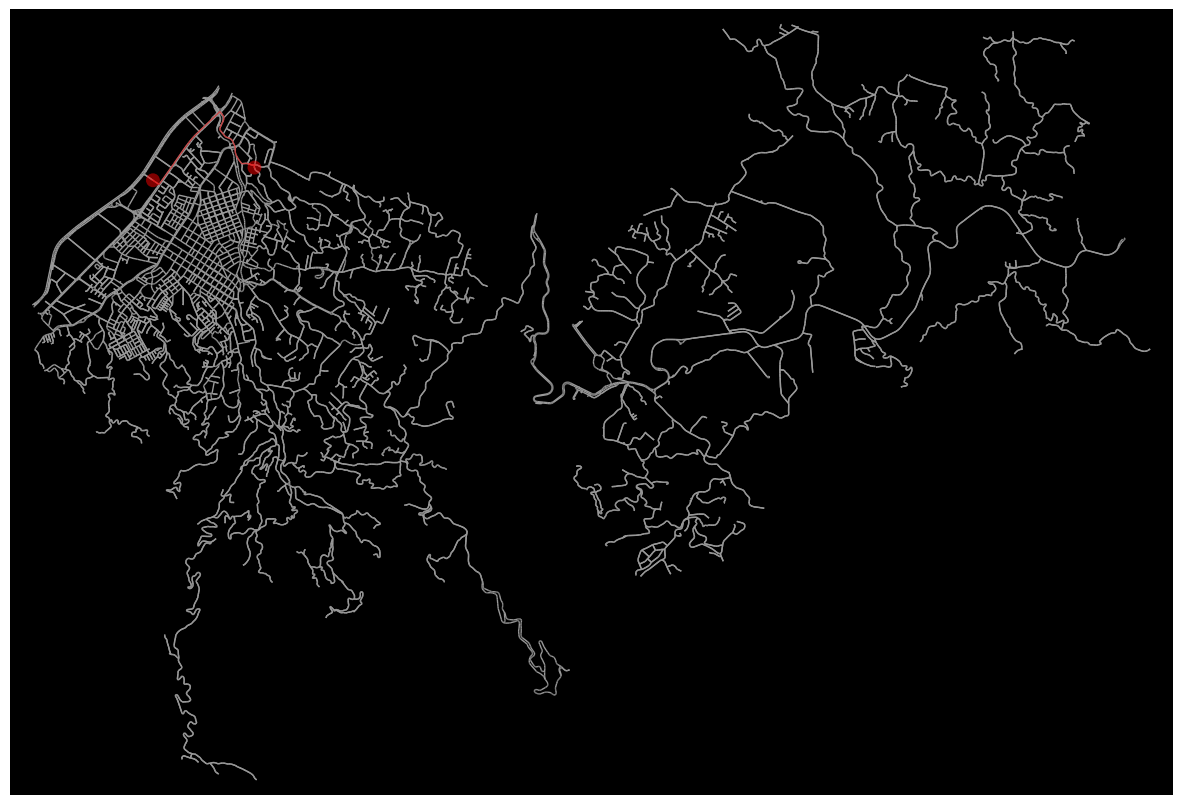

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [ ]:
tiempo_total = sum(G_proj.edges[u, v, 0]['travel_time_penalizado'] for u, v in zip(ruta_astar[:-1], ruta_astar[1:]))
distancia_total = sum(G_proj.edges[u, v, 0]['length'] for u, v in zip(ruta_astar[:-1], ruta_astar[1:]))

print(f"La mejor ruta considerando heurística realista y penalizaciones tiene {distancia_total:.0f} m y tarda {tiempo_total:.1f} segundos.")

ox.plot_graph_route(G_proj, ruta_astar, route_linewidth=1, node_size=0, bgcolor='k', figsize=(15, 15))


In [ ]:
print(ruta_astar)

[9397052814, 340686744, 340686745, 340686746, 5532256386, 4404924416, 340686061, 4321952286, 8458050797, 340686062, 4404924423, 9397071822, 2417951901, 6133923008, 4404924428, 6133923014, 9397071820, 10699863666, 2946094146, 3576471299, 9397071819, 3576471306, 3576471311, 4404924432, 6133923007, 10313189031, 3576471333, 10313189035, 327431061, 1673517680, 5496887614, 340688187, 3576471373, 569680297, 3576471506, 340688185, 3576471512, 569680298, 3576471517, 3503101974, 3576471519, 340688183, 10699863700, 569680299, 340688182, 8670491993, 8670491992, 8670491991, 8670491990, 8670491989, 3576471534, 6927580880, 5496798838, 340688179, 3576471541, 3576471544, 3576471547, 3576471548, 11986724591, 11986724590, 11986724594, 3576471553, 3572607010, 3576471557, 340688176, 9413105670, 10537092213, 322009433, 9413105669, 11986724652, 3572607015, 8670491978, 8670491979, 11986703617, 9413105671, 9413144203, 1279232869, 1278433424, 567932581, 10537092227, 567932583, 5919419199, 11986703602, 357647151

> **Esto me lo busqué para comprobar si estaba el** `travel_time_penalizado`



In [ ]:
for i, (u, v, k, d) in enumerate(G_proj.edges(keys=True, data=True)):
    if i == 10:
        break
    print(f"{u}->{v} key={k}  tt_penal={d.get('travel_time_penalizado')}")

309313450->414940715 key=0  tt_penal=6.737941987297922
309313450->440765240 key=0  tt_penal=11.573183388877816
414940715->309313451 key=0  tt_penal=6.966621877891388
414940715->309313450 key=0  tt_penal=6.737941987297922
440765240->440765238 key=0  tt_penal=20.184552604951122
440765240->5324852837 key=0  tt_penal=8.042916192548946
440765240->309313450 key=0  tt_penal=11.573183388877816
309313451->414940727 key=0  tt_penal=6.910702265678982
309313451->414940715 key=0  tt_penal=6.966621877891388
414940727->9400446431 key=0  tt_penal=5.873135452369648


In [ ]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(ruta_astar[:-1], ruta_astar[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [ ]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)),
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"])
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,9397052814,340686744,-75.579015,6.179106,-75.579029,6.179189,9,2
1,340686744,340686745,-75.579029,6.179189,-75.579025,6.179278,10,2
2,340686745,340686746,-75.579025,6.179278,-75.578987,6.179407,15,3
3,340686746,5532256386,-75.578987,6.179407,-75.579115,6.179400,14,3
4,5532256386,4404924416,-75.579115,6.179400,-75.579207,6.179403,10,2


In [ ]:
import plotly_express as px
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12, width=1000, height=600, mapbox_style='open-street-map')
fig.add_trace(px.scatter_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig